# Setting up Colab GPU

This notebook is run on Colab GPU.

In [1]:
!git clone https://github.com/liuzhimei/M2_coursework.git
%cd M2_coursework

Cloning into 'M2_coursework'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 86 (delta 37), reused 49 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (86/86), 3.64 MiB | 35.80 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/M2_coursework


In [2]:
!nvidia-smi --gpu-reset
!nvidia-smi

GPU 00000000:00:03.0 is currently in use by another process.

1 device is currently being used by one or more other processes (e.g., Fabric Manager, CUDA application, graphics application such as an X server, or a monitoring application such as another instance of nvidia-smi). Please first kill all processes using this device and all compute applications running in the system.
Tue Mar 25 14:02:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|===================================

In [1]:
import h5py
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM

torch.cuda.empty_cache()

/Users/zhimeiliu/Downloads/DIS/dis_sheet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading data from **lotka_volterra_data.h5**

In [4]:
with h5py.File("data/lotka_volterra_data.h5", "r") as f:
    # Access the full dataset
    trajectories = f["trajectories"][:]
    time_points = f["time"][:]

print(np.shape(trajectories))
print(np.shape(time_points))
print(time_points)

(1000, 100, 2)
(100,)
[  0.           2.02020202   4.04040404   6.06060606   8.08080808
  10.1010101   12.12121212  14.14141414  16.16161616  18.18181818
  20.2020202   22.22222222  24.24242424  26.26262626  28.28282828
  30.3030303   32.32323232  34.34343434  36.36363636  38.38383838
  40.4040404   42.42424242  44.44444444  46.46464646  48.48484848
  50.50505051  52.52525253  54.54545455  56.56565657  58.58585859
  60.60606061  62.62626263  64.64646465  66.66666667  68.68686869
  70.70707071  72.72727273  74.74747475  76.76767677  78.78787879
  80.80808081  82.82828283  84.84848485  86.86868687  88.88888889
  90.90909091  92.92929293  94.94949495  96.96969697  98.98989899
 101.01010101 103.03030303 105.05050505 107.07070707 109.09090909
 111.11111111 113.13131313 115.15151515 117.17171717 119.19191919
 121.21212121 123.23232323 125.25252525 127.27272727 129.29292929
 131.31313131 133.33333333 135.35353535 137.37373737 139.39393939
 141.41414141 143.43434343 145.45454545 147.47474747 1

## Plot dataset

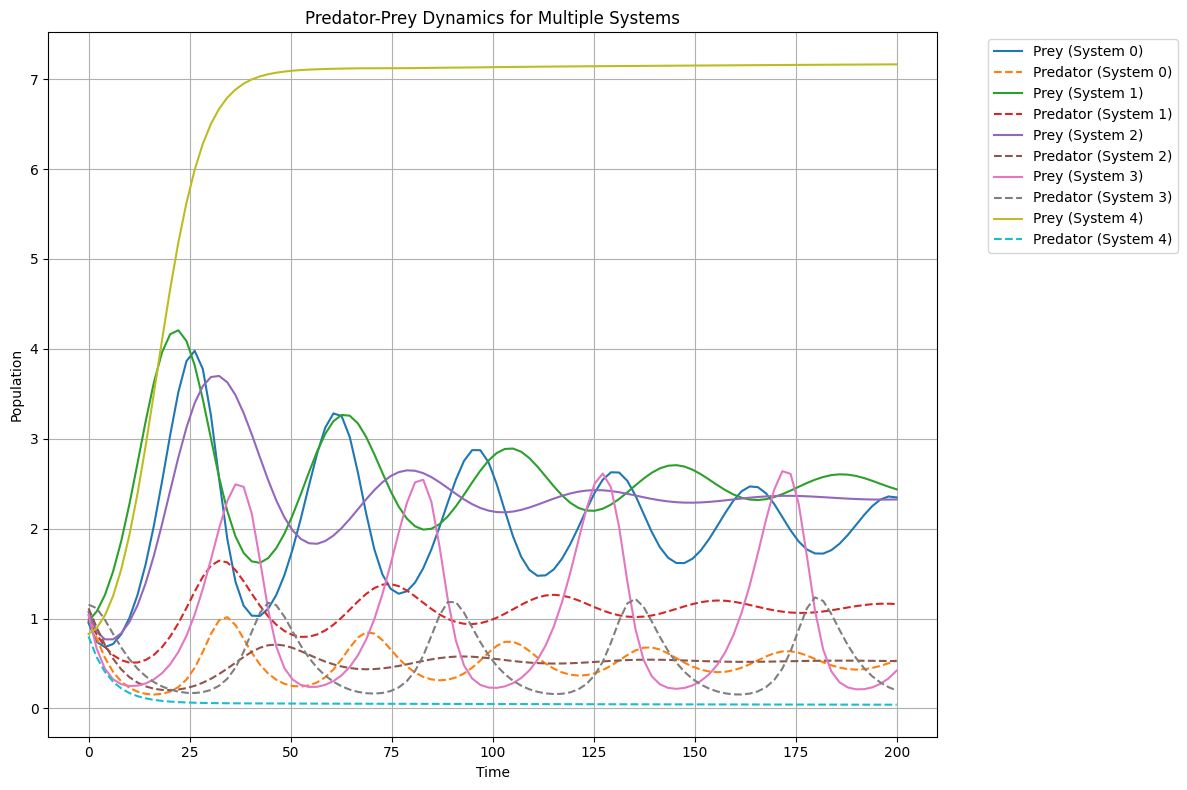

In [5]:
def plot_predator_prey():
    # Plot multiple systems
    num_systems = 5  # Number of systems to plot
    plt.figure(figsize=(12, 8))

    for system_id in range(num_systems):
        prey = trajectories[system_id, :, 0]
        predator = trajectories[system_id, :, 1]
        times = time_points[:]

        # Plot prey and predator population over time
        plt.plot(times, prey, label=f"Prey (System {system_id})", linestyle="-")
        plt.plot(times, predator, label=f"Predator (System {system_id})", linestyle="--")

    # Add labels and legend
    plt.title("Predator-Prey Dynamics for Multiple Systems")
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_predator_prey()

# Question 2 (a): LLMTIME Preprocessing Scheme

In [6]:
from src.preprocessor import preprocess_time_series, tokenize_sequence

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [2]:
model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(tokenizer("1.23", return_tensors="pt")["input_ids"].tolist()[0])
# [16, 13, 17, 18]
print(tokenizer("1 . 2 3", return_tensors="pt")["input_ids"].tolist()[0])
# [16, 659, 220, 17, 220, 18]

[16, 13, 17, 18]
[16, 659, 220, 17, 220, 18]


In [8]:
# Example system
def test(system_id):
    prey = trajectories[system_id, :, 0]
    predator = trajectories[system_id, :, 1]
    data = np.column_stack((prey, predator))

    # Preprocess the data
    preprocessed_sequence = preprocess_time_series(data)
    print("\nPreprocessed Sequence:")
    print(preprocessed_sequence)

    # Tokenize the sequence
    tokenized_sequence = tokenize_sequence(preprocessed_sequence)
    print("\nTokenized Sequence:")
    print(tokenized_sequence)

test(0)


Preprocessed Sequence:
1.900,2.081;1.481,1.559;1.364,1.129;1.433,0.815;1.649,0.601;2.009,0.460;2.526,0.372;3.211,0.324;4.062,0.309;5.046,0.324;6.082,0.375;7.036,0.474;7.728,0.643;7.955,0.903;7.551,1.260;6.511,1.659;5.102,1.963;3.768,2.030;2.818,1.854;2.286,1.550;2.063,1.238;2.057,0.976;2.217,0.777;2.524,0.637;2.968,0.547;3.541,0.498;4.219,0.487;4.956,0.512;5.670,0.579;6.248,0.694;6.563,0.867;6.505,1.095;6.038,1.351;5.248,1.577;4.344,1.694;3.547,1.667;2.982,1.519;2.663,1.315;2.551,1.109;2.606,0.933;2.801,0.797;3.118,0.702;3.538,0.646;4.038,0.625;4.575,0.639;5.090,0.689;5.508,0.778;5.747,0.906;5.744,1.066;5.476,1.239;4.991,1.391;4.398,1.480;3.827,1.484;3.374,1.406;3.082,1.278;2.950,1.132;2.961,0.996;3.094,0.884;3.330,0.802;3.649,0.751;4.025,0.731;4.423,0.741;4.796,0.782;5.090,0.853;5.253,0.950;5.248,1.067;5.064,1.188;4.736,1.290;4.330,1.351;3.924,1.357;3.585,1.309;3.352,1.223;3.236,1.120;3.234,1.018;3.332,0.930;3.514,0.864;3.762,0.822;4.051,0.806;4.350,0.815;4.622,0.849;4.830,0.906;4.93

# Question 2 (b): Evaluate the untrained Qwen2.5-Instruct model’s forecasting ability

In [13]:
def decode_time_series(generated_text, alpha=0.5, max_time_steps=20):
    """
    Decodes a generated time-series string of texts back into numerical data.

    Args:
        generated_text (str): Preprocessed string in LLMTIME format. e.g. ;6.398,1.204;6.676,1.310;6.891,1.446
        alpha (float): Scaling factor used during preprocessing (default is 0.5).
        max_time_steps (int): Maximum number of time steps to decode (default is 20).

    Returns:
        np.ndarray: Decoded time-series data of shape (T, 2).
    """
    # Remove leading semicolon if it exists
    generated_text = generated_text.lstrip(";")

    # Split the string into time steps and filter out any empty strings
    time_steps = [step for step in generated_text.split(";") if step]

    # Convert each pair of values back to float and reverse scaling
    data = []
    for i, step in enumerate(time_steps):
        if i >= max_time_steps:  # Stop after decoding max_time_steps
            break

        # Check if the step is in the correct format (i.e., contains exactly two values separated by a comma)
        if len(step.split(",")) == 2:
            try:
                prey, predator = map(float, step.split(","))
                data.append([prey * alpha, predator * alpha])
            except ValueError:
                print(f"Skipping invalid data (non-float values): {step}")
        else:
            print(f"Skipping malformed data: {step}")

    return np.array(data, dtype=np.float32)

decode_time_series(';6.398,1.204;6.676,1.310;6.891,1.446') # check the function

array([[3.199 , 0.602 ],
       [3.338 , 0.655 ],
       [3.4455, 0.723 ]], dtype=float32)

System:   0%|          | 0/6 [00:00<?, ?it/s]

generated tokens: [26, 19, 13, 24, 16, 21, 11, 15, 13, 23, 23, 15, 26, 20, 13, 16, 22, 19, 11, 15, 13, 24, 15, 23, 26, 20, 13, 19, 17, 22, 11, 15, 13, 24, 20, 20, 26, 20, 13, 20, 19, 24, 11, 16, 13, 15, 23, 23, 26, 20, 13, 21, 17, 21, 11, 16, 13, 18, 15, 15, 26, 20, 13, 20, 20, 17, 11, 16, 13, 20, 17, 24, 26, 20, 13, 18, 20, 15, 11, 16, 13, 21, 23, 18, 26, 19, 13, 22, 17, 18, 11, 16, 13, 23, 20, 21, 26, 19, 13, 16, 17, 15, 11, 17, 13, 15, 18, 24, 26, 17, 13, 22, 16, 17, 11, 17, 13, 17, 17, 16, 26, 16, 13, 22, 20, 23, 11, 17, 13, 18, 18, 21, 26, 16, 13, 21, 16, 17, 11, 17, 13, 19, 24, 24, 26, 16, 13, 19, 22, 15, 11, 17, 13, 21, 20, 15, 26, 16, 13, 18, 16, 18, 11, 17, 13, 23, 19, 17, 26, 16, 13, 15, 17, 24, 11, 18, 13, 15, 21, 22, 26, 15, 13, 23, 15, 23, 11, 18, 13, 18, 21, 20, 26, 15, 13, 19, 19, 23, 11, 18, 13, 22, 17, 23, 26, 15, 13, 17, 19, 23, 11, 19, 13, 15, 21, 16, 26, 15, 13, 16, 15, 22, 11, 19, 13, 19, 23, 23, 26, 4142, 15, 13, 16, 17, 18, 11, 19, 13, 24, 21, 16, 26, 4142, 15, 1

System:  17%|█▋        | 1/6 [12:00<1:00:04, 720.81s/it]

generated tokens: [26, 20, 13, 15, 18, 23, 11, 15, 13, 23, 21, 18, 26, 20, 13, 15, 21, 17, 11, 15, 13, 23, 18, 22, 26, 20, 13, 17, 23, 24, 11, 15, 13, 23, 23, 21, 26, 20, 13, 17, 17, 22, 11, 15, 13, 24, 19, 16, 26, 20, 13, 17, 17, 22, 11, 16, 13, 15, 17, 18, 26, 20, 13, 16, 22, 21, 11, 16, 13, 16, 15, 22, 26, 20, 13, 15, 15, 15, 11, 16, 13, 16, 21, 16, 26, 19, 13, 22, 20, 16, 11, 16, 13, 17, 18, 20, 26, 19, 13, 16, 19, 15, 11, 16, 13, 18, 16, 21, 26, 18, 13, 22, 22, 23, 11, 16, 13, 18, 23, 20, 26, 18, 13, 18, 18, 16, 11, 16, 13, 19, 17, 19, 26, 18, 13, 18, 16, 20, 11, 16, 13, 19, 22, 20, 26, 18, 13, 18, 23, 19, 11, 16, 13, 20, 16, 16, 26, 18, 13, 20, 20, 19, 11, 16, 13, 20, 20, 20, 26, 18, 13, 22, 20, 23, 11, 16, 13, 22, 15, 20, 26, 19, 13, 16, 19, 19, 11, 16, 13, 23, 15, 18, 26, 19, 13, 21, 22, 20, 11, 16, 13, 24, 23, 16, 26, 20, 13, 15, 20, 22, 11, 17, 13, 17, 23, 18, 26, 20, 13, 20, 21, 15, 11, 17, 13, 21, 19, 20, 26, 21, 13, 15, 24, 21, 11, 18, 13, 16, 22, 18, 26, 21, 13, 16, 17, 2

System:  33%|███▎      | 2/6 [24:00<48:01, 720.44s/it]  

generated tokens: [26, 19, 13, 21, 20, 22, 11, 17, 13, 18, 20, 18, 26, 19, 13, 20, 21, 17, 11, 17, 13, 18, 18, 21, 26, 19, 13, 19, 23, 16, 11, 17, 13, 18, 16, 24, 26, 19, 13, 19, 18, 15, 11, 17, 13, 17, 23, 21, 26, 19, 13, 18, 23, 15, 11, 17, 13, 17, 21, 21, 26, 19, 13, 18, 18, 15, 11, 17, 13, 17, 18, 20, 26, 19, 13, 17, 24, 23, 11, 17, 13, 17, 15, 20, 26, 19, 13, 17, 21, 24, 11, 17, 13, 16, 21, 23, 26, 19, 13, 17, 18, 23, 11, 17, 13, 16, 18, 23, 26, 19, 13, 17, 16, 15, 11, 17, 13, 16, 15, 15, 26, 19, 13, 17, 15, 22, 11, 17, 13, 15, 22, 15, 26, 19, 13, 16, 23, 20, 11, 17, 13, 15, 19, 17, 26, 19, 13, 16, 21, 21, 11, 17, 13, 15, 16, 17, 26, 19, 13, 16, 20, 17, 11, 16, 13, 24, 24, 20, 26, 19, 13, 16, 18, 21, 11, 16, 13, 24, 21, 24, 26, 19, 13, 16, 17, 19, 11, 16, 13, 24, 19, 22, 26, 19, 13, 16, 16, 16, 11, 16, 13, 24, 17, 20, 26, 19, 13, 16, 15, 17, 11, 16, 13, 23, 24, 24, 26, 19, 13, 15, 24, 15, 11, 16, 13, 23, 22, 16, 26, 19, 13, 15, 23, 16, 11, 16, 13, 23, 19, 17, 26, 19, 13, 15, 22, 1

System:  50%|█████     | 3/6 [36:01<36:01, 720.34s/it]

generated tokens: [26, 19, 13, 21, 19, 23, 11, 16, 13, 15, 18, 19, 26, 19, 13, 21, 17, 24, 11, 16, 13, 15, 18, 18, 26, 19, 13, 21, 15, 18, 11, 16, 13, 15, 17, 24, 26, 19, 13, 20, 23, 19, 11, 16, 13, 15, 17, 22, 26, 19, 13, 20, 22, 16, 11, 16, 13, 15, 17, 18, 26, 19, 13, 20, 21, 15, 11, 16, 13, 15, 17, 15, 26, 19, 13, 20, 19, 24, 11, 16, 13, 15, 16, 23, 26, 19, 13, 20, 19, 20, 11, 16, 13, 15, 16, 22, 26, 19, 13, 20, 20, 17, 11, 16, 13, 15, 16, 19, 26, 19, 13, 20, 20, 15, 11, 16, 13, 15, 16, 18, 26, 19, 13, 20, 20, 16, 11, 16, 13, 15, 16, 17, 26, 19, 13, 20, 18, 22, 11, 16, 13, 15, 16, 15, 26, 19, 13, 20, 19, 19, 11, 16, 13, 15, 15, 24, 26, 19, 13, 20, 18, 18, 11, 16, 13, 15, 15, 23, 26, 19, 13, 20, 17, 24, 11, 16, 13, 15, 15, 23, 26, 19, 13, 20, 17, 21, 11, 16, 13, 15, 15, 22, 26, 19, 13, 20, 17, 16, 11, 16, 13, 15, 15, 22, 26, 19, 13, 20, 17, 19, 11, 16, 13, 15, 15, 22, 26, 19, 13, 20, 18, 20, 11, 16, 13, 15, 15, 20, 26, 19, 13, 20, 19, 15, 11, 16, 13, 15, 15, 18, 26, 19, 13, 20, 19, 2

System:  67%|██████▋   | 4/6 [48:01<24:00, 720.38s/it]

generated tokens: [26, 17, 13, 17, 17, 16, 11, 15, 13, 17, 23, 24, 26, 17, 13, 23, 15, 18, 11, 15, 13, 18, 23, 24, 26, 18, 13, 22, 15, 20, 11, 15, 13, 19, 22, 18, 26, 19, 13, 16, 23, 19, 11, 15, 13, 21, 15, 19, 26, 19, 13, 20, 21, 24, 11, 15, 13, 23, 24, 22, 26, 19, 13, 24, 19, 17, 11, 16, 13, 15, 23, 22, 26, 19, 13, 22, 18, 22, 11, 16, 13, 19, 22, 15, 26, 19, 13, 15, 17, 24, 11, 16, 13, 24, 24, 17, 26, 18, 13, 21, 23, 21, 11, 17, 13, 19, 17, 19, 26, 17, 13, 20, 15, 19, 11, 17, 13, 23, 16, 20, 26, 16, 13, 22, 24, 18, 11, 18, 13, 16, 21, 16, 26, 15, 13, 23, 15, 22, 11, 18, 13, 17, 23, 24, 26, 15, 13, 21, 19, 22, 11, 18, 13, 19, 19, 24, 26, 15, 13, 20, 17, 20, 11, 18, 13, 20, 22, 19, 26, 15, 13, 19, 22, 20, 11, 18, 13, 23, 18, 16, 26, 15, 13, 19, 24, 20, 11, 19, 13, 16, 20, 19, 26, 15, 13, 21, 15, 16, 11, 19, 13, 19, 19, 15, 26, 15, 13, 21, 23, 17, 11, 19, 13, 22, 19, 21, 26, 15, 13, 22, 15, 19, 11, 20, 13, 15, 24, 15, 26, 15, 13, 22, 22, 24, 11, 20, 13, 20, 16, 17, 26, 15, 13, 23, 22, 2

System:  83%|████████▎ | 5/6 [1:00:44<12:15, 735.71s/it]

generated tokens: [26, 16, 19, 13, 18, 15, 24, 11, 15, 13, 15, 23, 22, 26, 16, 19, 13, 18, 16, 15, 11, 15, 13, 15, 23, 23, 26, 16, 19, 13, 18, 16, 16, 11, 15, 13, 15, 23, 23, 26, 16, 19, 13, 18, 16, 17, 11, 15, 13, 15, 23, 23, 26, 16, 19, 13, 18, 16, 18, 11, 15, 13, 15, 23, 22, 26, 16, 19, 13, 18, 16, 19, 11, 15, 13, 15, 23, 22, 26, 16, 19, 13, 18, 16, 20, 11, 15, 13, 15, 23, 22, 26, 16, 19, 13, 18, 16, 21, 11, 15, 13, 15, 23, 21, 26, 16, 19, 13, 18, 16, 22, 11, 15, 13, 15, 23, 21, 26, 16, 19, 13, 18, 16, 24, 11, 15, 13, 15, 23, 21, 26, 16, 19, 13, 18, 17, 15, 11, 15, 13, 15, 23, 20, 26, 16, 19, 13, 18, 17, 16, 11, 15, 13, 15, 23, 20, 26, 16, 19, 13, 18, 17, 17, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 17, 18, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 17, 19, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 17, 20, 11, 15, 13, 15, 23, 19, 26, 16, 19, 13, 18, 17, 21, 11, 15, 13, 15, 23, 18, 26, 16, 19, 13, 18, 17, 22, 11, 15, 13, 15, 23, 18, 26, 16, 19, 13, 18, 17, 23, 11, 15, 13, 15, 2

System: 100%|██████████| 6/6 [1:12:45<00:00, 727.54s/it]

generated tokens: [26, 15, 13, 19, 18, 21, 11, 16, 13, 16, 17, 22, 26, 15, 13, 19, 18, 16, 11, 15, 13, 23, 21, 16, 26, 15, 13, 19, 18, 23, 11, 15, 13, 21, 24, 18, 26, 15, 13, 19, 18, 15, 11, 15, 13, 20, 17, 20, 26, 15, 13, 19, 18, 15, 11, 15, 13, 18, 20, 16, 26, 15, 13, 19, 19, 20, 11, 15, 13, 16, 23, 19, 26, 15, 13, 19, 20, 24, 11, 15, 13, 16, 16, 24, 26, 15, 13, 19, 16, 21, 11, 15, 13, 16, 16, 21, 26, 15, 13, 19, 16, 21, 11, 15, 13, 16, 15, 20, 26, 15, 13, 19, 16, 21, 11, 15, 13, 15, 24, 20, 26, 15, 13, 20, 16, 15, 11, 15, 13, 16, 17, 24, 26, 15, 13, 21, 19, 19, 11, 15, 13, 16, 20, 15, 26, 15, 13, 22, 18, 16, 11, 15, 13, 17, 19, 16, 26, 15, 13, 23, 18, 23, 11, 15, 13, 17, 20, 20, 26, 15, 13, 23, 24, 17, 11, 15, 13, 18, 17, 16, 26, 15, 13, 23, 24, 17, 11, 15, 13, 18, 19, 15, 26, 15, 13, 23, 24, 17, 11, 15, 13, 18, 19, 24, 26, 15, 13, 23, 24, 17, 11, 15, 13, 18, 20, 22, 26, 15, 13, 23, 24, 17, 11, 15, 13, 18, 21, 21, 26, 15, 13, 23, 24, 17, 11, 15, 13, 18, 22, 20, 26, 15, 13, 23, 24, 1

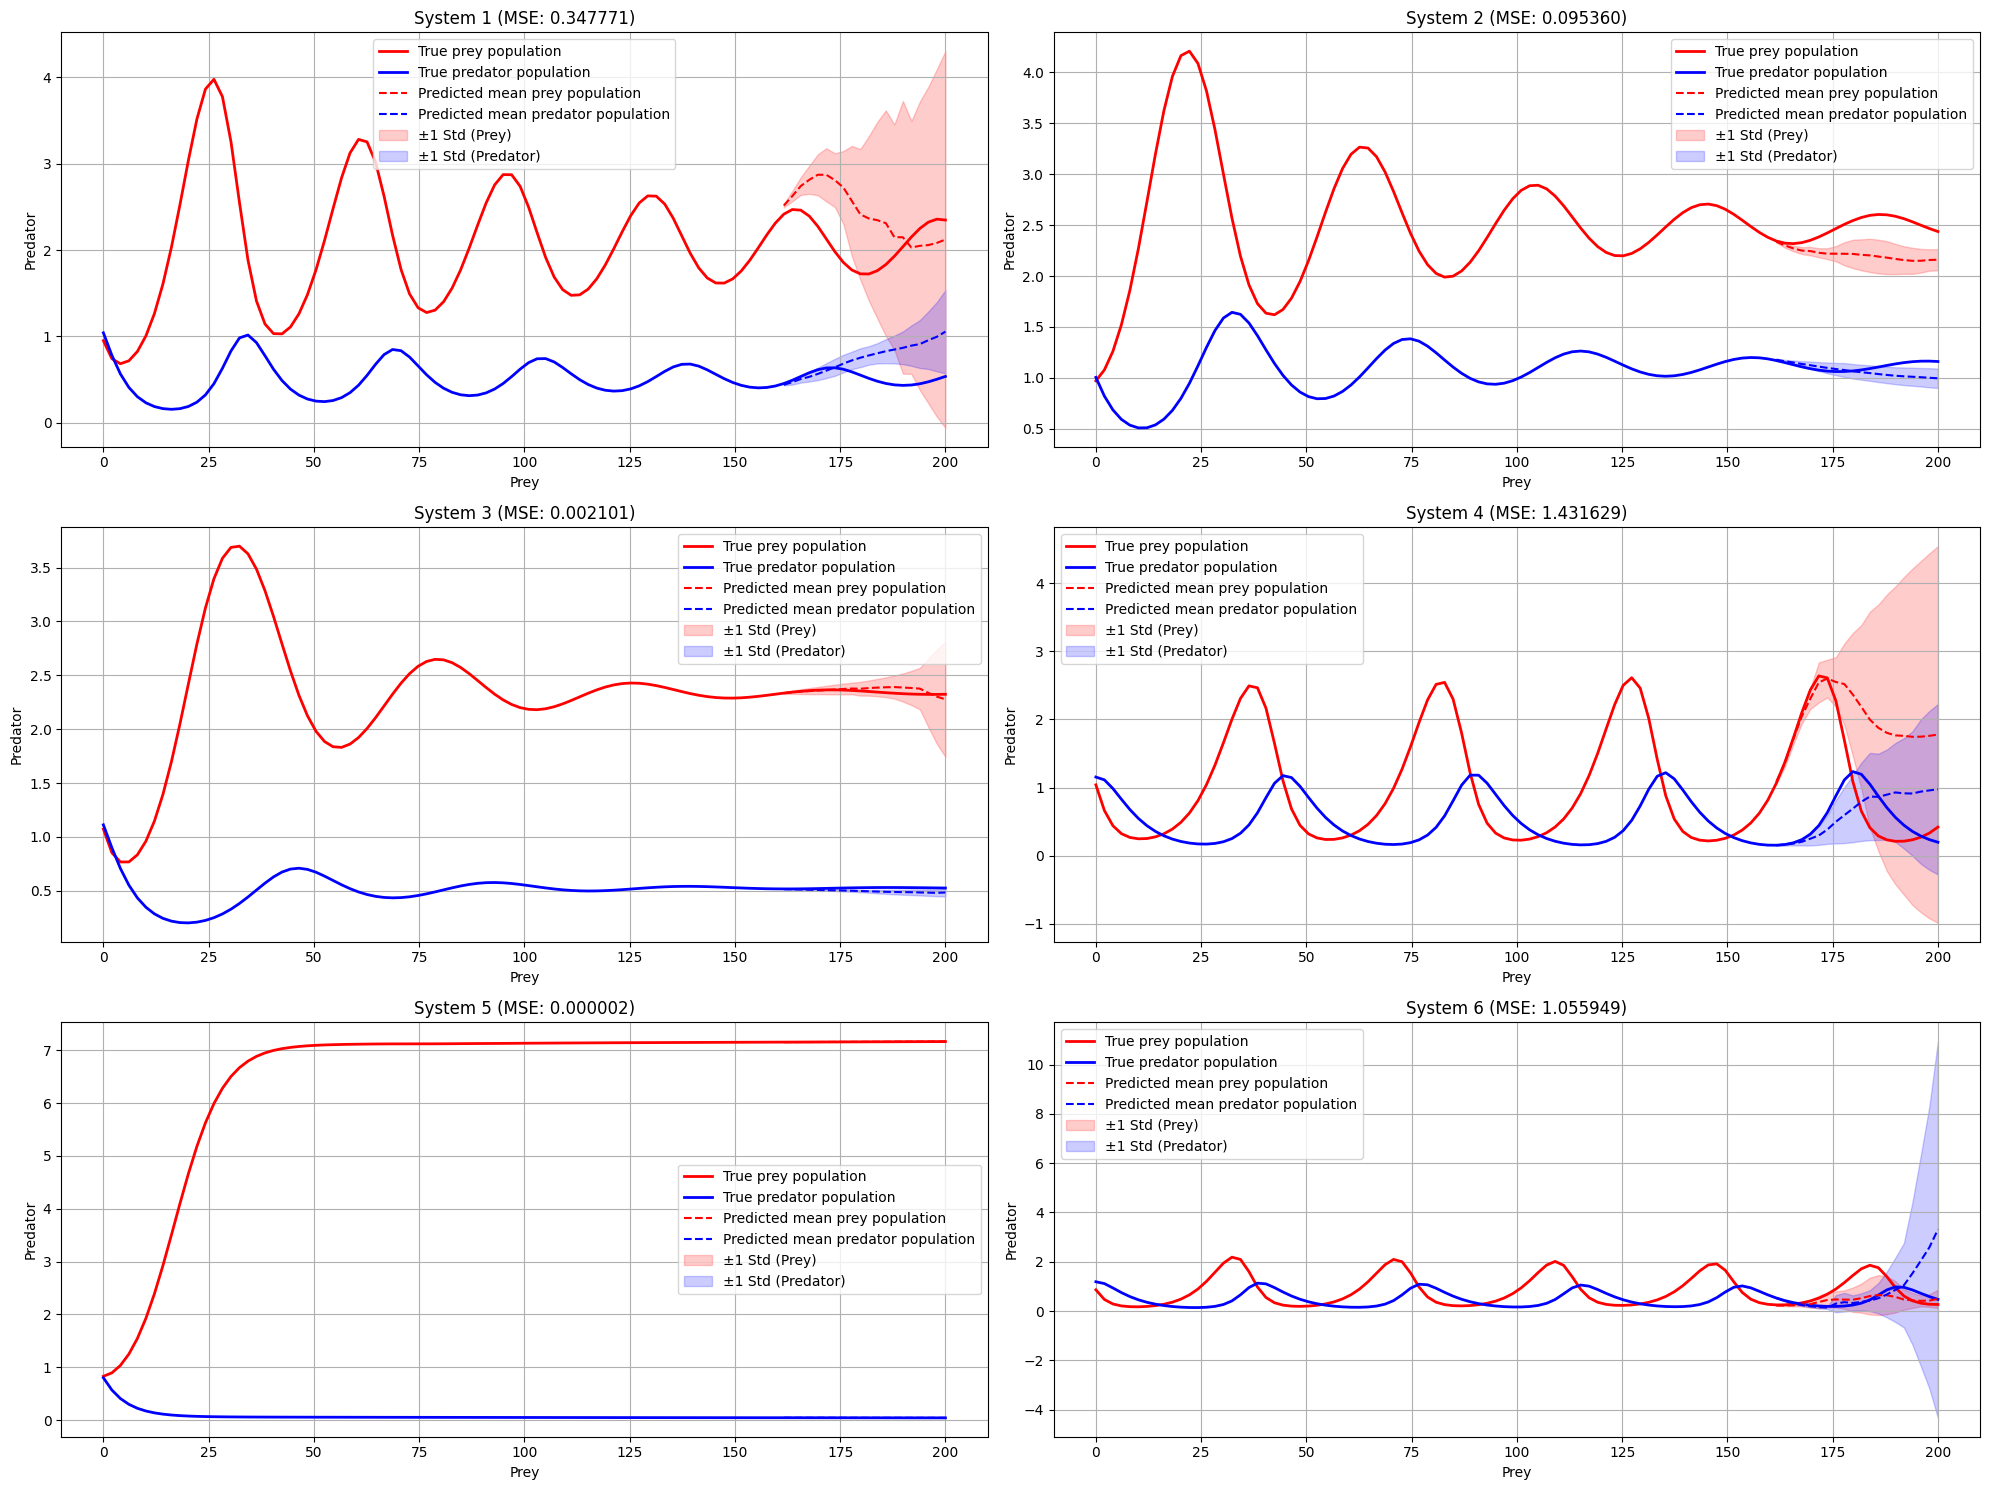

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(model_name)
model = model.to(device)

model.eval()

def plot_predictions(model, tokenizer):
    plt.figure(figsize=(20, 15))

    for system_id in tqdm(range(6), desc="System"):
        prey = trajectories[system_id, :, 0] # a list of 100 points for population of prey
        predator = trajectories[system_id, :, 1] # a list of 100 points for population of predator

        raw_data = np.column_stack((prey[:80], predator[:80])) # only stack the first 80 time steps (shape: (80,2))

        preprocessed_text = preprocess_time_series(raw_data) # apply LLMTIME scheme to convert raw data to texts

        tokenized_input = tokenize_sequence(preprocessed_text)  # use Qwen2.5 to tokenize the text (looks like [17, 13, ...])

        # Generate predictions (repeat for stochastic models to get variance)
        num_samples = 10  # Number of samples to estimate uncertainty
        num_tokens = 400 # predict 20 time steps need many tokens (for decimal=3)
        preds = []

        for _ in range(num_samples):
            input_tensor = torch.tensor(tokenized_input, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

            # Autoregressive prediction for next num_token number of tokens
            generated_tokens = []
            for _ in range(num_tokens):
                with torch.no_grad():
                    output = model(input_tensor)
                    # next_token = output.logits[:, -1, :].argmax(dim=-1).unsqueeze(0)  # Get most likely next token

                    # Define temperature for randomness (variability) to the autoregressive predictions
                    temperature = 1.0 
                    logits = output.logits[:, -1, :] / temperature  # Adjust logits with temperature
                    probs = torch.nn.functional.softmax(logits, dim=-1)
                    next_token = torch.multinomial(probs, 1)  # Sample from the distribution

                    generated_tokens.append(next_token.item())

                    # Append predicted token to input for next step
                    input_tensor = torch.cat([input_tensor, next_token], dim=1) # final form: tensor([[17, 18, 13, ...]])

            # Decode generated tokens back to time series data
            print(f"generated tokens: {generated_tokens}")
            generated_text = tokenizer.decode(generated_tokens)
            print(f"generated text: {generated_text}")

            generated_series = decode_time_series(generated_text)  # Convert texts back to numerical series and truncate the series at 100 time step

            # Only add if the shape is correct and no NaNs are present
            if generated_series is not None and generated_series.shape == (20, 2) and not np.isnan(generated_series).any():
                preds.append(generated_series)
            else:
                print(f"Skipping invalid sample with shape: {generated_series.shape}")


        preds = np.array(preds)  # Shape: (num_samples, T=20, 2)
        mean_pred = np.mean(preds, axis=0)
        std_pred = np.std(preds, axis=0)

        # Calculate the MSE for each system
        prey_mse = np.mean((mean_pred[:, 0] - prey[80:]) ** 2)
        predator_mse = np.mean((mean_pred[:, 1] - predator[80:]) ** 2)
        total_mse = prey_mse + predator_mse
        print(f"The MSE for system {system_id + 1} is: {total_mse:.6f}")

        # Plot true series
        plt.subplot(3, 2, system_id + 1)
        plt.plot(time_points, prey, label=f'True prey population', color='red', linewidth=2)
        plt.plot(time_points, predator, label=f'True predator population', color='blue', linewidth=2)

        # Plot predicted mean with dashed line
        plt.plot(time_points[80:], mean_pred[:, 0], label='Predicted mean prey population', color='red', linestyle='--')
        plt.plot(time_points[80:], mean_pred[:, 1], label='Predicted mean predator population', color='blue', linestyle='--')

        # Plot shaded area for 1 standard deviation
        plt.fill_between(time_points[80:],
                        mean_pred[:, 0] - std_pred[:, 0],
                        mean_pred[:, 0] + std_pred[:, 0],
                        color='red', alpha=0.2, label='±1 Std (Prey)')

        plt.fill_between(time_points[80:],
                 mean_pred[:, 1] - std_pred[:, 1],
                 mean_pred[:, 1] + std_pred[:, 1],
                 color='blue', alpha=0.2, label='±1 Std (Predator)')

        plt.title(f'System {system_id + 1} (MSE: {total_mse:.6f})')
        plt.xlabel('Prey')
        plt.ylabel('Predator')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_predictions(model, tokenizer)